# Exemple of training workflow using a sklearn `Pipeline`

The workflow is composed of the following steps:
- read data
- basic analysis of data
- define pipeline
- train and evaluate predictions
- Cross-Validation (CV), here with `KFold`
- Find optimal parameters, here with `GridSearchCV`

This workflow takes around 5min to complete

The final pipeline looks like this:
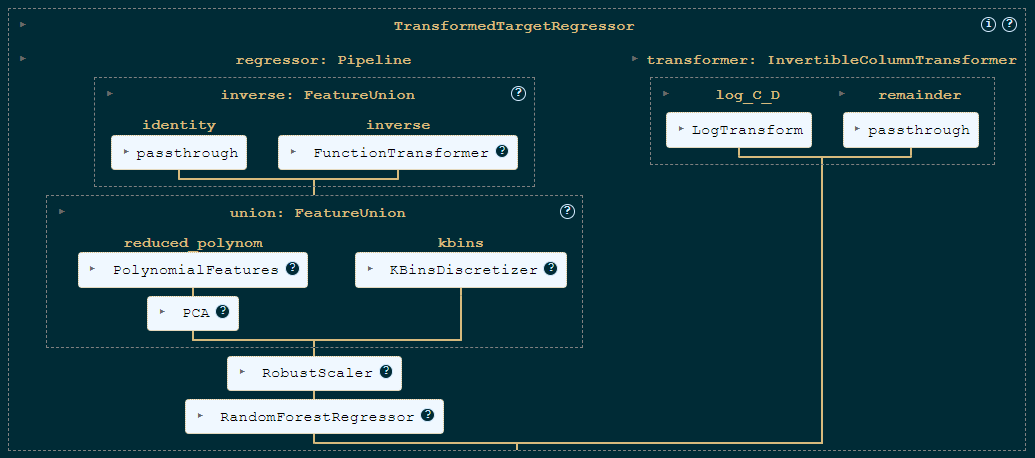

## Imports
### basic imports

In [1]:
import os
import sys
import time
import yaml
import rich
from tqdm import tqdm
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### scikit-learn imports

In [2]:
# base classes to implement our own transforms and models
from sklearn.base import TransformerMixin, BaseEstimator

# transforms, preprocessings and models
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, PowerTransformer, QuantileTransformer
from sklearn.preprocessing import PolynomialFeatures, KBinsDiscretizer, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor

# composition of transforms and models
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor

# evaluation
from sklearn.metrics import r2_score #, root_mean_squared_error

# hp-tuning and validation
from sklearn.model_selection import GridSearchCV, LeaveOneOut, KFold

### PLAID imports

In [3]:
from plaid.containers.sample import Sample
from plaid.containers.dataset import Dataset
from plaid.problem_definition import ProblemDefinition

## Data loading

In [5]:
# data_dir = Path('/gpfs_new/cold-data/InputData/public_datasets/AI4Design/AirfRANS/converted_plaid/meshes_cliped_tri_remeshed')
data_dir = Path('<path-to-AirfRANS-dataset-in-PLAID-format>')

In [ ]:
dataset = Dataset(data_dir/'dataset')
print(dataset)

In [ ]:
problem_definition = ProblemDefinition(data_dir/'problem_definition')
problem_definition

In [ ]:
splits = problem_definition.get_split()
splits.keys()

In [ ]:
input_scalars_names = problem_definition.get_input_scalars_names()
print(f"{input_scalars_names=}")

In [ ]:
output_scalars_names = problem_definition.get_output_scalars_names()
print(f"{output_scalars_names=}")

In [ ]:
scalars = dataset.get_scalars_to_tabular()
scalars.keys()

In [12]:
X = np.concatenate([scalars[isn].reshape((-1,1)) for isn in input_scalars_names], axis=1)
y = np.concatenate([scalars[osn].reshape((-1,1)) for osn in output_scalars_names], axis=1)

In [13]:
X_train = X[splits['full_train']]
y_train = y[splits['full_train']]
X_test = X[splits['full_test']]
y_test = y[splits['full_test']]

## Basic data analysis

In [14]:
scalars['test'] = np.zeros(len(dataset), dtype=bool)
scalars['test'][splits['full_test']] = True

In [ ]:
scalars_pd = pd.DataFrame(scalars)
scalars_pd

In [ ]:
fig = plt.figure(figsize=(10,6))
for i_feat in range(len(input_scalars_names)):
    isn = input_scalars_names[i_feat]
    ax = fig.add_subplot(1,len(input_scalars_names),i_feat+1)
    sns.violinplot(data=scalars_pd, y=isn, hue="test", split=True, inner='quart', gap=0.1, legend=True)
    ax.set_title(isn)
plt.suptitle('input scalars')
plt.tight_layout()
plt.show()

In [ ]:
fig = plt.figure(figsize=(10,6))
for i_feat in range(len(output_scalars_names)):
    isn = output_scalars_names[i_feat]
    ax = fig.add_subplot(1,len(output_scalars_names),i_feat+1)
    sns.violinplot(data=scalars_pd, y=isn, hue="test", split=True, inner='quart', gap=0.1, legend=True)
    ax.set_title(isn)
plt.suptitle('output scalars')
plt.tight_layout()
plt.show()

We can see that the distribution of output scalar C_D is squashed close to 0, a log transform should better spread the samples

In [ ]:
scalars_pd['C_D'].min()

In [ ]:
scalars_pd['log_C_D'] = np.log10(scalars_pd['C_D'])
fig = plt.figure(figsize=(6,6))
sns.violinplot(data=scalars_pd, y='log_C_D', hue="test", split=True, inner='quart', gap=0.1, legend=True)
plt.tight_layout()
plt.show()

## Pipeline definition

In [20]:
class InverseTransform(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass
    def fit(self,*args,**kargs):
        return self
    def transform(self,x):
        return np.concatenate([x,1 / x], axis=1)
    def inverse_transform(self,x):
        return x[:,:x.shape[1]//2]

#---# this methods are useless as we inherit from BaseEstimator
    # def get_params(self,*args,**kargs):
    #     return {'scale':self.scale, 'offset':self.offset}
        # return {'scale':self.scale, 'inv_scale':self.inv_scale, 'offset':self.offset}
    # def set_params(self, **parameters):
    #     for parameter, value in parameters.items():
    #         setattr(self, parameter, value)
    #     return self

In [ ]:
nb_pca_components = 32
nb_trees = 1024

inverse = FeatureUnion([
    ('identity', 'passthrough'),
    ('inverse', FunctionTransformer(func=(lambda x:1.0/x), inverse_func=(lambda x:1.0/x))),
])

regressor = Pipeline([
                      ('inverse',inverse),
                      ('union',FeatureUnion([
                                             ('reduced_polynom',Pipeline([
                                                                          ('polynom',PolynomialFeatures(degree=3, include_bias=False)),
                                                                          ('pca',PCA(n_components=8)),
                                                                         ])),
                                             ('kbins',KBinsDiscretizer()),
                                            ])),
                      ('scaler',RobustScaler(with_centering=False)),
                      # ('pca',PCA(n_components=nb_pca_components)),
                      ('model',RandomForestRegressor(n_estimators=nb_trees,
                                                     oob_score=True,
                                                     n_jobs=4,
                                                     verbose=0,
                                                    )),
                     ])
regressor

As we have seen previously, to better spread the distribution of output scalar C_D, we apply a LogTransform to this output 
This is done using: 
- ``TransformedTargetRegressor``, that transform a target before trying to fit a regressor to it
- ``InvertibleColumnTransformer``, that apply a transform (here ``LogTransform``) to only a chosen set of columns 

In [22]:
class LogTransform(TransformerMixin, BaseEstimator):
    def __init__(self,scale=1.0,offset=0.0):
        self.scale = scale
        self.inv_scale = 1.0/scale
        self.offset = offset
    def fit(self,*args,**kargs):
        return self
    def transform(self,x):
        nb_samples = x.shape[0]
        return np.log(self.scale * x + self.offset).reshape((nb_samples,-1))
    def inverse_transform(self,x):
        nb_samples = x.shape[0]
        return self.inv_scale * (np.exp(x)-self.offset).reshape((nb_samples,-1))

#---# this methods are useless as we inherit from BaseEstimator
    # def get_params(self,*args,**kargs):
    #     return {'scale':self.scale, 'offset':self.offset}
        # return {'scale':self.scale, 'inv_scale':self.inv_scale, 'offset':self.offset}
    # def set_params(self, **parameters):
    #     for parameter, value in parameters.items():
    #         setattr(self, parameter, value)
    #     return self

In [23]:
class InvertibleColumnTransformer(ColumnTransformer):
    """
    Adds an inverse transform method to the standard sklearn.compose.ColumnTransformer.

    Warning this is flaky and use at your own risk.  Validation checks that the column count in
    `transformers` are in your object `X` to be inverted.  Reordering of columns will break things!
    """
    def inverse_transform(self, X):

        # check that remainder is set to 'passthrough' (only if there are remaining columns)
        if len(self._remainder[2])==0 or self._remainder[1] == 'passthrough':

            all_input_ids = list(self._transformer_to_input_indices.values())
            all_input_ids = sorted(np.concatenate(all_input_ids).flatten())

            # check that all columns are treated, and only ones
            if np.all(np.arange(self.n_features_in_) == all_input_ids):
                #------------------------------------------------------------------------------------------------#
                #---# From https://github.com/scikit-learn/scikit-learn/issues/11463#issuecomment-1674435238 #---#
                #------------------------------------------------------------------------------------------------#
                if isinstance(X,pd.DataFrame):
                    X = X.to_numpy()

                arrays = []
                for name, indices in self.output_indices_.items():
                    transformer = self.named_transformers_.get(name, None)
                    arr = X[:, indices.start: indices.stop]

                    if transformer is None:
                        pass

                    else:
                        arr = transformer.inverse_transform(arr)

                    arrays.append(arr)

                retarr = np.concatenate(arrays, axis=1)

                if retarr.shape[1] != X.shape[1]:
                    raise ValueError(f"Received {X.shape[1]} columns but transformer expected {retarr.shape[1]}")

                return retarr
                #------------------------------------------------------------------------------------------------#

            else:
                raise ValueError(f"only {all_input_ids} input columns are treated, but all input columns should be treated (there are {self.n_features_in_})")
        else:
            raise ValueError(f"remainder set to '{self._remainder[1]}' but should be 'passthrough'")

In [ ]:
# pipeline = TransformedTargetRegressor(regressor=regressor)
pipeline = TransformedTargetRegressor(regressor=regressor, transformer=InvertibleColumnTransformer([('log_C_D',LogTransform(),0)], remainder='passthrough'))
pipeline

## Training

In [ ]:
pipeline.fit(X_train,y_train)

In [ ]:
pipeline.regressor_[-1].oob_score_

In [ ]:
oob_pred_train = pipeline.transformer_.inverse_transform(pipeline.regressor_[-1].oob_prediction_)
r2_score(y_train, oob_pred_train, multioutput='raw_values')

## Evaluate predictions

In [28]:
pred_train = pipeline.predict(X_train)
pred_test = pipeline.predict(X_test)

In [ ]:
r2_score(y_train, pred_train, multioutput='raw_values')

In [ ]:
r2_score(y_test, pred_test, multioutput='raw_values')

## KFold Cross-Validation

There are many cross-validation (CV) methods, will see here the simplest: KFold cross-validation.

For a comparison of different CV methods (in the case of classification) see: https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py

In [31]:
kf = KFold(n_splits=10, shuffle=True)

In [ ]:
r2 = []
oob = []
for i, (train_index, test_index) in tqdm(enumerate(kf.split(X_train)), desc='Treat KFold', total=kf.get_n_splits()):
    # print(f"--- Fold {i}:")
    # print(f"  {len(train_index)=} -> {train_index[:10]}")
    # print(f"  {len(test_index)=}  -> {test_index[:10]}")

    inverse = FeatureUnion([
        ('identity', 'passthrough'),
        ('inverse', FunctionTransformer(func=(lambda x:1.0/x), inverse_func=(lambda x:1.0/x))),
    ])

    regressor = Pipeline([
                      ('inverse',inverse),
                      ('union',FeatureUnion([
                                             ('reduced_polynom',Pipeline([
                                                                          ('polynom',PolynomialFeatures(degree=3, include_bias=False)),
                                                                          ('pca',PCA(n_components=8)),
                                                                         ])),
                                             ('kbins',KBinsDiscretizer()),
                                            ])),
                      ('scaler',RobustScaler(with_centering=False)),
                      # ('pca',PCA(n_components=nb_pca_components)),
                      ('model',RandomForestRegressor(n_estimators=nb_trees,
                                                     oob_score=True,
                                                     n_jobs=4,
                                                     verbose=0,
                                                    )),
                     ])
    pipeline = TransformedTargetRegressor(regressor=regressor, transformer=InvertibleColumnTransformer([('log_C_D',LogTransform(),0)], remainder='passthrough'))

    # train
    pipeline.fit(X_train[train_index], y_train[train_index])

    oob.append(pipeline.regressor_[-1].oob_score_)

    # evaluate
    y_true = y_train[test_index]
    y_pred = pipeline.predict(X_train[test_index])
    r2.append(r2_score(y_true, y_pred, multioutput='raw_values'))

In [ ]:
for i_fold in range(kf.get_n_splits()):
    print(f" - {i_fold} -> r2={r2[i_fold]}, oob={oob[i_fold]}")

In [ ]:
np.mean(oob)

In [ ]:
np.mean(r2,axis=0)

In [ ]:
np.std(r2,axis=0)

In [ ]:
print(f"{X_train.shape=}")
print(f"{pipeline.regressor_[:1].transform(X_train).shape=}")
print(f"{pipeline.regressor_[1]['reduced_polynom'][0].transform(pipeline.regressor_[0].transform(X_train)).shape=}")
print(f"{pipeline.regressor_[1]['kbins'].transform(pipeline.regressor_[0].transform(X_train)).shape=}")
print(f"{pipeline.regressor_[:2].transform(X_train).shape=}")
print(f"{pipeline.regressor_[:3].transform(X_train).shape=}")
print(f"{pipeline.regressor_.predict(X_train).shape=}")

In [ ]:
pipeline.get_params()

## Find optimal parameters

In [ ]:
param_grid = {
    'regressor__model__n_estimators': [64,128,256,512],
    'regressor__union__reduced_polynom__polynom__degree': [3,4],
    'regressor__union__reduced_polynom__pca__n_components': [2,4,8],
}
grid_cv = GridSearchCV(pipeline, param_grid=param_grid, grid_cv=kf, refit=True, verbose=2)
grid_cv

In [ ]:
grid_cv.fit(X_train, y_train)

In [ ]:
grid_cv.cv_results_.keys()

In [ ]:
# print(f"{grid_cv.cv_results_['mean_fit_time']=}")
# print(f"{grid_cv.cv_results_['std_fit_time']=}")
# print(f"{grid_cv.cv_results_['mean_score_time']=}")
# print(f"{grid_cv.cv_results_['std_score_time']=}")
print(f"{grid_cv.cv_results_['mean_test_score']=}")
print(f"{grid_cv.cv_results_['std_test_score']=}")
print(f"{grid_cv.cv_results_['rank_test_score']=}")

In [ ]:
print(f"{grid_cv.cv_results_['param_regressor__model__n_estimators']=}")
print(f"{grid_cv.cv_results_['param_regressor__union__reduced_polynom__pca__n_components']=}")
print(f"{grid_cv.cv_results_['param_regressor__union__reduced_polynom__polynom__degree']=}")
print(f"{grid_cv.cv_results_['params']=}")

In [ ]:
best_case_id = np.argmin(grid_cv.cv_results_['rank_test_score'])
best_case_id

In [ ]:
print(f"{grid_cv.cv_results_['param_regressor__model__n_estimators'][best_case_id]=}")
print(f"{grid_cv.cv_results_['param_regressor__union__reduced_polynom__pca__n_components'][best_case_id]=}")
print(f"{grid_cv.cv_results_['param_regressor__union__reduced_polynom__polynom__degree'][best_case_id]=}")
print(f"{grid_cv.cv_results_['params'][best_case_id]=}")